In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 1000

 - https://scikit-learn.org/stable/modules/impute.html
 - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer
 - https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_23_0.html#sphx-glr-auto-examples-release-highlights-plot-release-highlights-0-23-0-py
 - https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [2]:
from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(40)

In [3]:
d = pd.read_pickle('data.pickle')

In [4]:
d.head()

measurekey,BC,CO,NO,NO2,O3,PM-10.0,PM-2.5,RH,SO2,T,WD,WS
start,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,NaN,3.0,19.5,33.0,27.0,21.9,NaN,9.0,7.70,235.0,3.400
2019-01-01 01:00:00,NaN,0.185,3.0,17.5,32.5,16.5,13.5,93.0,7.5,7.05,225.0,3.260
2019-01-01 02:00:00,NaN,0.205,4.5,28.0,23.0,7.0,5.2,93.0,6.5,7.05,246.0,3.030
2019-01-01 03:00:00,NaN,0.200,3.0,19.0,32.5,9.5,7.5,86.0,6.5,7.10,229.0,2.895
2019-01-01 04:00:00,NaN,0.205,3.0,15.0,36.0,13.0,11.0,83.5,7.0,7.15,224.0,2.910


In [20]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
set_config(display='diagram')

In [7]:
imputer = KNNImputer(n_neighbors=24, weights="distance", add_indicator=False)
scaler = make_pipeline(imputer, StandardScaler())
transformer = imputer

In [8]:
regressor = RandomForestRegressor(n_estimators=150, random_state=1234, verbose=1)

In [9]:
pipe = make_pipeline(transformer, regressor)

In [10]:
X = d.copy()

In [11]:
y = transformer.fit_transform(X.pop('PM-2.5').to_frame())

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
pipe.fit(X_train, y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.7s finished


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('knnimputer',
                                  KNNImputer(n_neighbors=24,
                                             weights='distance')),
                                 ('standardscaler', StandardScaler())])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=150, random_state=1234,
                                       verbose=1))])

In [14]:
prediction = pipe.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


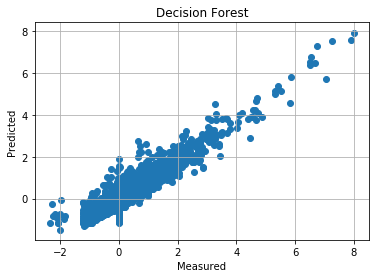

In [15]:
fig, axe = plt.subplots()
axe.scatter(y_test, prediction)
axe.set_xlabel('Measured')
axe.set_ylabel('Predicted')
axe.set_title('Decision Forest')
axe.grid()

In [16]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


0.9096517357012359

In [17]:
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, prediction)))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, prediction))
print('R-squared: %.2f' % r2_score(y_test, prediction))

Root mean squared error: 0.30
Mean absolute error: 0.20
R-squared: 0.91


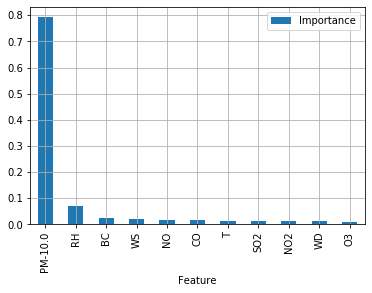

In [18]:
s = pd.DataFrame(np.array([X.columns, pipe.steps[-1][1].feature_importances_]).T,
                 columns=['Feature', 'Importance']).set_index('Feature')
s = s.sort_values('Importance', ascending=False)
axe = s[:15].plot(kind='bar')
axe.grid()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


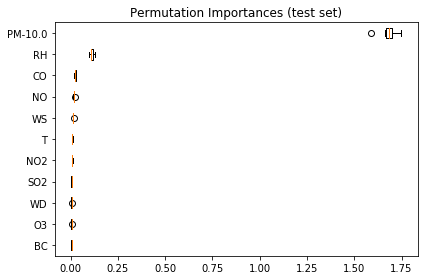

In [21]:
result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()